In [1]:
import pandas as pd
import os

Selecting all CSV Files and areas from the Unzipped Directory

In [2]:
path = 'data/unzipped/'
files = os.listdir(path)
csv_files=list(map(lambda x: x if(x[-4:]=='.csv') else "", files))
areas = sorted(list(set([file[:5] for file in csv_files])))

print(f"CSV: {len(csv_files)}  AREAS: {len(areas)}")

CSV: 71254  AREAS: 1132


## Dataset Creation

Building a Dictionary datasets (For max temperature, min temperature and precipitations)

In [3]:
def create_dataset(feature: str):
    data = {    
        "AREA":[],
        # feature :[]
    }
    
    # create date keys
    suff_list = ["1970_d.csv","1971_d.csv","1972_d.csv"]
    
    for suff in suff_list:
        df = pd.read_csv(path+f"00019_{suff}")
        for i in range(len(df['PragaDate'])):
            data[df['PragaDate'][i]]=[]
    
    
    for area in areas:
        # print(area, end="\r")
        data["AREA"].append(area)

        for csv in sorted([file for file in csv_files if file.startswith(area) and list(filter(file.endswith, suff_list)) != []]): 
            print(path+csv, end="\r")
            df = pd.read_csv(path+csv)
            for i in range(len(df['PragaDate'])):
                data[df['PragaDate'][i]].append(df[feature][i])
    dataset = pd.DataFrame.from_dict(data)
    return dataset
    

In [62]:
for feature in ["DAILY_TMIN","DAILY_TMAX","DAILY_PREC"]:
    print(feature,":")
    dataset = create_dataset(feature)
    dataset.to_json(f"data/{feature}_dataset.json", orient='records')


DAILY_TMIN :
DAILY_TMAX :d/02315_1972_d.csv
DAILY_PREC :d/02315_1972_d.csv


In [63]:
! hdfs dfs -put data/DAILY_TMIN_dataset.json
! hdfs dfs -put data/DAILY_TMAX_dataset.json
! hdfs dfs -put data/DAILY_PREC_dataset.json

## Create Spark Session

In [3]:
import findspark

findspark.init()

import pyspark
from pyspark.sql import SparkSession



spark = SparkSession \
            .builder \
            .appName("BDAProject") \
            .config("spark.executor.memory","1100m")\
            .config("spark.executor.memoryOverhead","400m")\
            .master("yarn") \
            .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/12 19:31:47 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


## Create Schema

In [6]:
from pyspark.sql.types import StructType, StructField, DoubleType, StringType

suff_list = ["1970_d.csv","1971_d.csv","1972_d.csv"]

dates = []
for suff in suff_list:
    df = pd.read_csv(path+f"00019_{suff}")
    for i in range(len(df['PragaDate'])):
        dates.append(df['PragaDate'][i])
        
schema = StructType([StructField("AREA", StringType(), True)]+[ StructField(date, DoubleType(), True) for date in dates])

## Functions

In [30]:
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA, Normalizer
from pyspark.ml.clustering import KMeans, BisectingKMeans, GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator

def run_clustering(feature="PREC", n_components_pca = 2, clustering_function=KMeans, cluster_number=2):
    
    # Load Dataset
    sparkDF = spark.read.schema(schema).json(f"DAILY_{feature}_dataset.json")
    print(f"Dataframe Size: {(sparkDF.count(), len(sparkDF.columns))},  Total Entries: {sparkDF.count()*len(sparkDF.columns)}")
    
    # Get Column Names (used in vector assembler)
    
    column_names = [col[0] for col in sparkDF.dtypes]
    column_names = column_names[1:]
    
    # Vector-Assemble Dataset
    vecAssembler = VectorAssembler(outputCol="features")
    vecAssembler.setInputCols(column_names)
    sparkDF = vecAssembler.transform(sparkDF)
    
    # Dataset Scaling
    scaler = StandardScaler(
        inputCol = 'features', 
        outputCol = 'scaledFeatures',
        withMean = True,
        withStd = True
        ).fit(sparkDF)

    sparkDF = scaler.transform(sparkDF)

    # normalizer = Normalizer(p=2.0, inputCol='scaledFeatures', outputCol='normalizedFeatures')
    
    # sparkDF = normalizer.transform(sparkDF)
    
    ## PCA
    
    pca = PCA(
        k = n_components_pca, 
        inputCol = 'scaledFeatures', 
        outputCol = 'pcaFeatures'
        ).fit(sparkDF)

    sparkDF = pca.transform(sparkDF)
    
    
    
    
    # Cluster Model
    
    # cmethod = clustering_function(featuresCol="pcaFeatures").setK(cluster_number).setSeed(1)
    cmethod = clustering_function(featuresCol="features").setK(cluster_number).setSeed(1)
    model = cmethod.fit(sparkDF)

    predictions = model.transform(sparkDF)
    
    if clustering_function != BisectingKMeans:
        evaluator = ClusteringEvaluator()

        silhouette = evaluator.evaluate(predictions)
        print("Silhouette with squared euclidean distance = " + str(silhouette))
    
    df = predictions.select("pcaFeatures","AREA","prediction").toPandas()
    
    info = None
    if clustering_function==KMeans or clustering_function==BisectingKMeans:
        info = model.clusterCenters()
    elif clustering_function==GaussianMixture:
        info = model.gaussiansDF.toPandas()
        
    return df, info

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
# %matplotlib inline

def plot_map(df, colormap):
    eraclito_map = gpd.read_file('data/eraclito.geojson')
    eraclito_map = eraclito_map.sort_values(by=['Codice'])
    df=df.sort_values(by='AREA')
    eraclito_map['prediction_kmeans']=df['prediction']
    eraclito_map[:3]
    eraclito_map.plot(column="prediction_kmeans", cmap=colormap)
    

def plot_clusters(df, n_clusters):
    
    for i in range(n_clusters):
        filtered_label=df[df['prediction']==i]
        x=[]
        y=[]
        for pca in filtered_label['pcaFeatures']:
            x.append(pca[0])
            y.append(pca[1])
        plt.scatter(x , y)
    
    plt.show()

## Test

In [ ]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","blue"])
pred, centers = run_clustering(feature="PREC", n_components_pca = 2, clustering_function=KMeans, cluster_number=2)
print(f"Centers:{centers}")

Dataframe Size: (1131, 1097),  Total Entries: 1240707


- ### Kmeans on Precipitation Data (2 Clusters, 2 PCA components)

In [9]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","blue"])
pred, centers = run_clustering(feature="PREC", n_components_pca = 2, clustering_function=KMeans, cluster_number=2)
print(f"Centers:{centers}")

Dataframe Size: (1131, 1097),  Total Entries: 1240707
23/02/12 17:39:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


23/02/12 17:40:11 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/02/12 17:40:11 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Silhouette with squared euclidean distance = 0.6730530833117273


Centers:[array([ 3.91740587, -0.55304019]), array([-24.6670202 ,   3.48236921])]


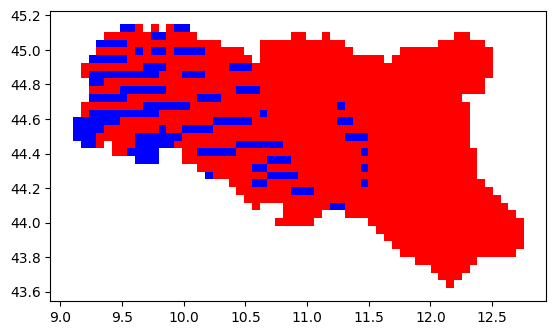

In [11]:
plot_map(pred, cmap)

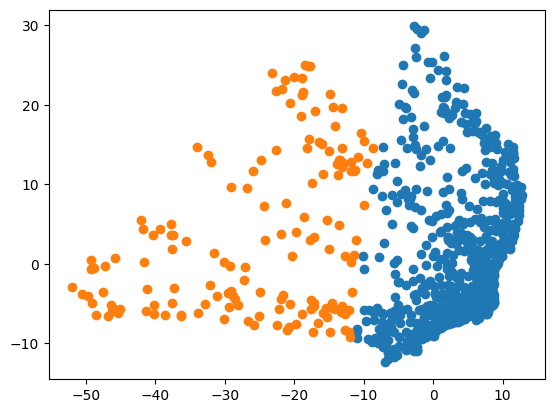

In [20]:
plot_clusters(pred, 2)

- ### Kmeans on Min Temperature Data (2 Clusters, 2 PCA components)

In [14]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","orange"])
pred, centers = run_clustering(feature="TMIN", n_components_pca = 2, clustering_function=KMeans, cluster_number=2)
print(f"Centers:{centers}")


Dataframe Size: (1131, 1097),  Total Entries: 1240707


Silhouette with squared euclidean distance = 0.6891755670396027


Centers:[array([-16.08425807,   0.7842179 ]), array([32.94888445, -1.60648411])]


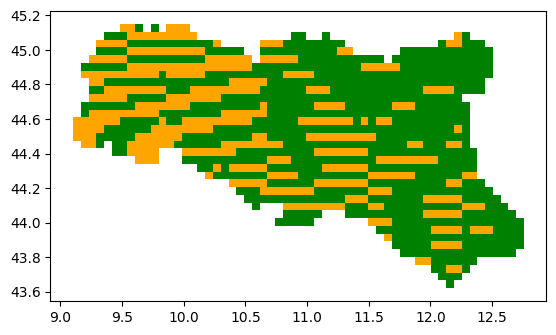

In [15]:
plot_map(pred, cmap)

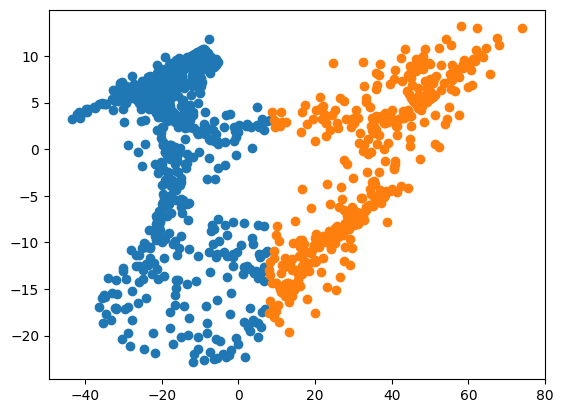

In [16]:
plot_clusters(pred, 2)

- ### GMM on MinTemperature Data (2 Clusters, 2 PCA components)

In [17]:
pred, gaussians = run_clustering(feature="TMIN", n_components_pca = 2, clustering_function=GaussianMixture, cluster_number=2)
print(f"Gaussians:{gaussians}")

Dataframe Size: (1131, 1097),  Total Entries: 1240707


Silhouette with squared euclidean distance = 0.3056840841315514


Gaussians:                                       mean  \
0  [-18.275248365702637, 7.064183493948058]   
1   [12.005718620681332, -4.64073579828153]   

                                                 cov  
0  DenseMatrix([[63.40659542, 11.77474817],\n    ...  
1  DenseMatrix([[699.30202327, 132.79067928],\n  ...  


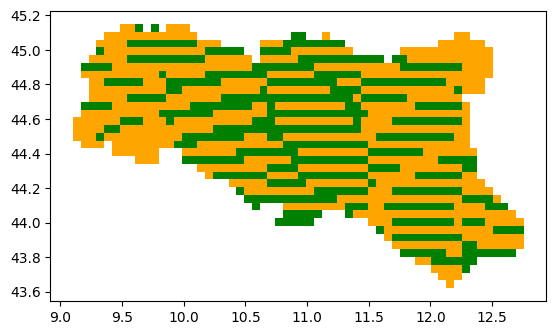

In [21]:
plot_map(pred, cmap)

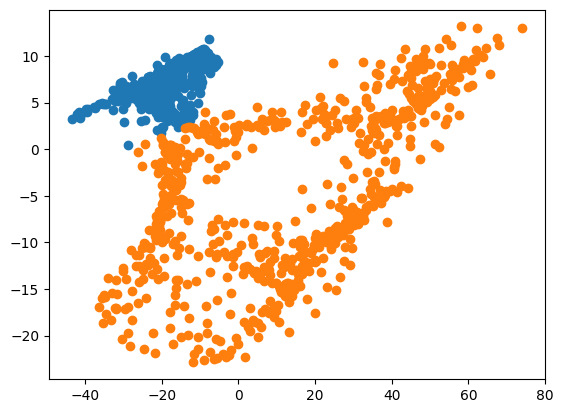

In [19]:
plot_clusters(pred,2)

- ### Kmeans on Maximum Temperature Data (2 Clusters, 2 PCA components)

In [24]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["teal","yellow"])
pred, centers = run_clustering(feature="TMAX", n_components_pca = 2, clustering_function=KMeans, cluster_number=2)
print(f"Centers:{centers}")


Dataframe Size: (1131, 1097),  Total Entries: 1240707


Silhouette with squared euclidean distance = 0.7357088225127474


Centers:[array([-15.03349989,   0.14352196]), array([38.26709063, -0.36532862])]


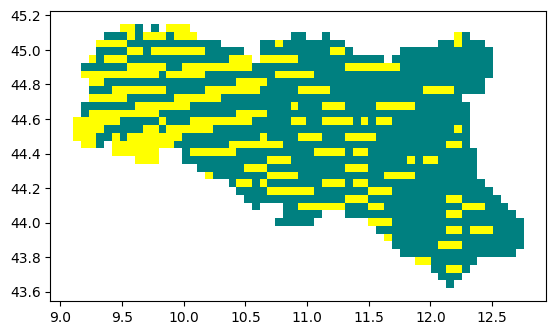

In [25]:
plot_map(pred, cmap)

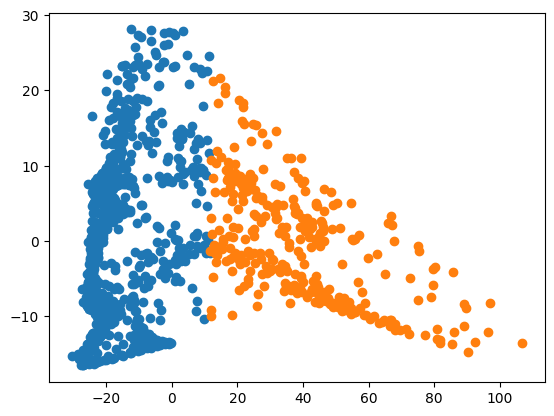

In [26]:
plot_clusters(pred,2)

- ### Kmeans on Maximum Temperature Data (3 Clusters, 2 PCA components)

In [27]:
pred, centers = run_clustering(feature="TMAX", n_components_pca = 2, clustering_function=KMeans, cluster_number=3)
print(f"Centers:{centers}")

Dataframe Size: (1131, 1097),  Total Entries: 1240707


Silhouette with squared euclidean distance = 0.6149848898189375


Centers:[array([-18.02323469,  -1.43751105]), array([52.19822072, -4.00711507]), array([13.87420746,  6.65989557])]


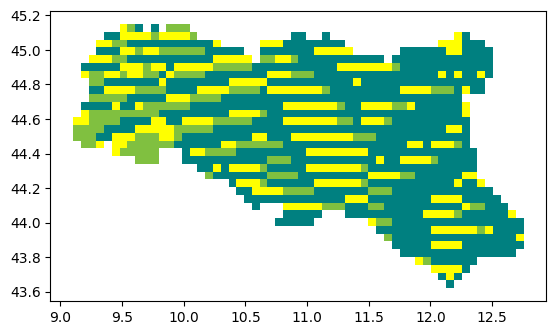

In [28]:
plot_map(pred, cmap)

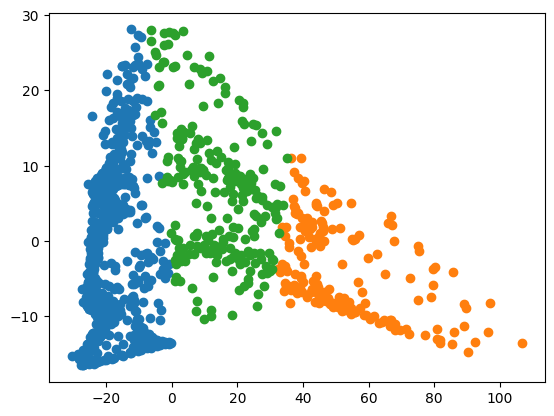

In [29]:
plot_clusters(pred,3)

- ### GMM on Maximum Temperature Data (2 Clusters, 2 PCA components)

In [7]:
pred, gaussians = run_clustering(feature="TMAX", n_components_pca = 2, clustering_function=GaussianMixture, cluster_number=2)
print(f"Gaussians:{gaussians}")

Dataframe Size: (1131, 1097),  Total Entries: 1240707
23/02/12 17:01:27 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


23/02/12 17:01:58 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/02/12 17:01:58 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Silhouette with squared euclidean distance = 0.667684811996938


Gaussians:                                         mean  \
0  [-18.000527627604846, -1.7267175432867983]   
1     [27.023088764749268, 2.592215206643801]   

                                                 cov  
0  DenseMatrix([[ 44.75837514,  20.28437798],\n  ...  
1  DenseMatrix([[ 601.55922811, -147.16259638],\n...  


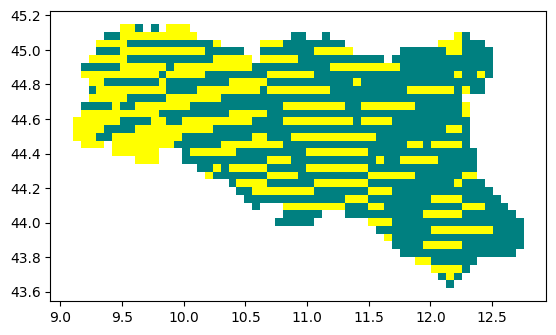

In [34]:
plot_map(pred, cmap)

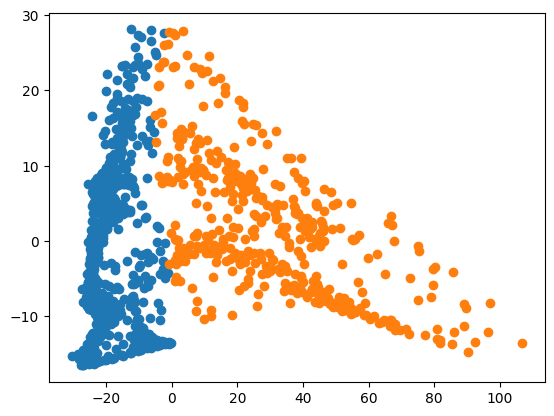

In [42]:
plot_clusters(pred,2)


- ### Bisecting Kmeans on Maximum Temperature Data (2 Clusters, 2 PCA components)

In [12]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["teal","yellow"])
pred, centers = run_clustering(feature="TMAX", n_components_pca = 2, clustering_function=BisectingKMeans, cluster_number=2)
print(f"Centers:{centers}")

Dataframe Size: (1131, 1097),  Total Entries: 1240707
23/02/12 18:17:54 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


23/02/12 18:18:26 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/02/12 18:18:26 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


Centers:[array([6.56513845e-16, 1.03063250e-14])]


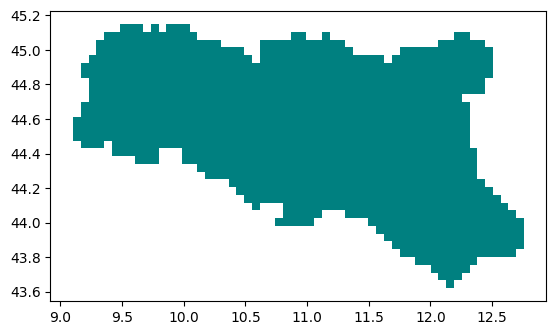

In [13]:
plot_map(pred, cmap)

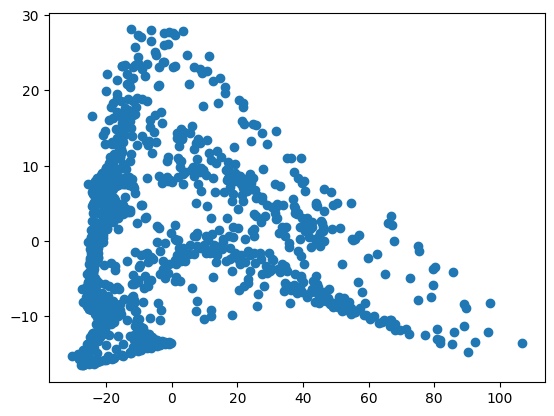

In [15]:
plot_clusters(pred,2)

## Other Things

In [8]:
import numpy as np
from scipy.stats import multivariate_normal


def gauss2d(mu, sigma, to_plot=False):
    w, h = 100, 100

    std = [np.sqrt(sigma[0, 0]), np.sqrt(sigma[1, 1])]
    x = np.linspace(mu[0] - 3 * std[0], mu[0] + 3 * std[0], w)
    y = np.linspace(mu[1] - 3 * std[1], mu[1] + 3 * std[1], h)

    x, y = np.meshgrid(x, y)

    x_ = x.flatten()
    y_ = y.flatten()
    xy = np.vstack((x_, y_)).T

    normal_rv = multivariate_normal(mu, cov=sigma)
    z = normal_rv.pdf(xy)
    z = z.reshape(w, h, order='F')

    if to_plot:
        plt.contourf(x, y, z.T)
        # plt.show()

    return z
